# image classification of fashion MNIST using residual network 

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
import numpy as np
import sklearn
import pandas as pd

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## load fashion MNIST dataset

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [5]:
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

## scale dataset

In [6]:
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [7]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

## build model

In [8]:
#residual network (ResNet)

In [9]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [10]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[28, 28, 1]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        3136      
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 7, 7, 64)          74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 7, 7, 64)          74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 7, 7, 64)          7

## compile model

In [12]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

## train model

In [13]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 126s 50ms/step - loss: 0.7328 - accuracy: 0.7673 - val_loss: 0.3806 - val_accuracy: 0.8600
Epoch 2/10
1719/1719 [==============================] - 84s 49ms/step - loss: 0.3532 - accuracy: 0.8717 - val_loss: 0.5902 - val_accuracy: 0.7806
Epoch 3/10
1719/1719 [==============================] - 84s 49ms/step - loss: 0.3222 - accuracy: 0.8852 - val_loss: 0.2892 - val_accuracy: 0.8880
Epoch 4/10
1719/1719 [==============================] - 84s 49ms/step - loss: 0.2698 - accuracy: 0.9016 - val_loss: 0.2651 - val_accuracy: 0.9054
Epoch 5/10
1719/1719 [==============================] - 84s 49ms/step - loss: 0.2500 - accuracy: 0.9102 - val_loss: 0.3255 - val_accuracy: 0.8882
Epoch 6/10
1719/1719 [==============================] - 84s 49ms/step - loss: 0.2214 - accuracy: 0.9182 - val_loss: 0.2612 - val_accuracy: 0.9074
Epoch 7/10
1719/1719 [==============================] - 85s 49ms/step - loss: 0.2168 - accuracy: 0.9236 - val_loss: 0.2746 

## learning curves

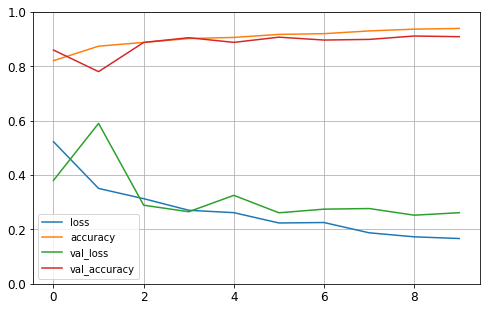

In [14]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [15]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [16]:
val_acc = history.history['val_accuracy']

In [17]:
np.argmax(val_acc) #epoch position of maximum; attention: position counted from zero; training output counted from one.

8

In [18]:
round(np.max(val_acc),4)

0.9116

## evaluate model

In [19]:
#check generalization accuracy on the test set

In [20]:
score = model.evaluate(X_test, y_test)

313/313 [==============================] - 4s 11ms/step - loss: 0.2624 - accuracy: 0.9059


In [21]:
round(score[1],4)

0.9059

## prediction

In [22]:
X_new = X_test[:10]  #new instances taken from test set

In [23]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([9, 2, 1, 1, 0, 1, 4, 6, 5, 7])

In [24]:
y_test[:10]  #check prediction

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], dtype=uint8)

In [25]:
np.array(class_names)[y_pred]  #convert class index to class name

array(['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'T-shirt/top',
       'Trouser', 'Coat', 'Shirt', 'Sandal', 'Sneaker'], dtype='<U11')

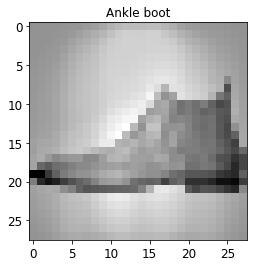

In [26]:
plt.imshow(X_new[0,...,0], cmap="binary", interpolation="nearest")
plt.title(class_names[y_test[0]], fontsize=12)
plt.show()